In [73]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely
import requests
from urllib.request import urlretrieve
import zipfile 
from sodapy import Socrata
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import statsmodels.formula.api as smf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist

from xgboost import XGBClassifier
%matplotlib inline

## Data Preparation ##

In [74]:
# Download original dataset -- Extremely Time Consuming!!
# 2016 Yellow Taxi Trip Data
# https://data.cityofnewyork.us/dataset/2016-Yellow-Taxi-Trip-Data/uacg-pexx
client = Socrata("data.cityofnewyork.us", None)
results = client.get("uacg-pexx", limit=1000000000)
complete_df = pd.DataFrame.from_records(results)

In [62]:
# randomly sampling the original dataset 
# The original dataset is too big for the project
# Export the sample to a csv file
# I shared the reduced dataframe on my github
# Set the random_state = 1 for reproducibility 

reduced_df = complete_df.sample(frac=0.02,random_state=1)
reduced_df.to_csv('Project_Data.csv')
reduced_df.shape

(2623301, 21)

In [64]:
# Drop unnecessary columns and missing variables

reduced_df.drop(columns=['VendorID','RatecodeID','store_and_fwd_flag','extra','mta_tax',
                         'improvement_surcharge','tolls_amount','PULocationID',
                         'DOLocationID'],inplace = True)

reduced_df.dropna(inplace = True)

In [65]:
# Load the shape file

urlretrieve(' https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip',
                   'ZIP_CODE_040114.zip')
fname = "ZIP_CODE_040114.zip"
zf = zipfile.ZipFile(fname)
zf.extractall()
nyczipsshp = gp.read_file("ZIP_CODE_040114.shp")

In [66]:
# Convert the dataframe to geodataframe

reduced_df['dropoff_lonlat']=list(zip(reduced_df.dropoff_longitude,reduced_df.dropoff_latitude))
reduced_df = gp.GeoDataFrame(reduced_df.drop(['dropoff_longitude', 'dropoff_latitude'], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[shapely.geometry.Point(x) for x in reduced_df.dropoff_lonlat])

In [67]:
# Standarize both gdf's epsg to 2263 for spaical join
reduced_df_c = reduced_df.to_crs(epsg=2263)
nyczipsshp_c = nyczipsshp.to_crs(epsg=2263)

In [79]:
# Spatial Join (in order to get the zipcode of the drop off location)
project_df = gp.sjoin(reduced_df_c, nyczipsshp_c)

In [82]:
# Drop unnecessary columns and missing variables
project_df = project_df[['ZIPCODE','tpep_pickup_datetime','passenger_count',
                         'trip_distance','payment_type','fare_amount','COUNTY','total_amount','tip_amount']]

project_df.dropna(inplace=True)

In [83]:
#load and join the home price data from zillow
#I only use the column for Median value per sq. ft.
#https://www.zillow.com/new-york-ny/home-values/
HPData = pd.read_csv("f", skiprows=2)[['Region Name','Current']].iloc[1:]
project_df  = pd.merge(project_df, HPData, left_on = 'ZIPCODE', right_on='Region Name',how='inner')

#Drop missing variable
project_df = project_df.loc[project_df['Current']!='---']
project_df = project_df.loc[project_df['Current']!='--']

project_df['dropoff_homeprice'] = project_df['Current'].str[1:].str.replace(',', '').astype('int')
project_df['dropoff_homeprice'][0:5]

0    634
1    634
2    634
3    634
4    634
Name: dropoff_homeprice, dtype: int64

In [84]:
#load the weather data from NOAA
#https://www.ncdc.noaa.gov/cdo-web/search

WeatherData = pd.read_csv("Weather.csv")
WeatherData['DATE'] = pd.to_datetime(WeatherData['DATE'],infer_datetime_format=True).dt.date

In [85]:
#Merge the dataset to get the weather data on the day of each trip

project_df['pickup_datetime'] = pd.to_datetime(project_df['tpep_pickup_datetime'], 
                                                      infer_datetime_format=True)

project_df['pickup_date'] = project_df['pickup_datetime'].dt.date
project_df = pd.merge(project_df, WeatherData, left_on = 'pickup_date', right_on='DATE',how='left')

In [87]:
# Create the "tip_rate" column
project_df['tip_rate'] = project_df['tip_amount'] / project_df['total_amount']

# Create the "pickup_time" column
project_df['pickup_time'] = project_df['pickup_datetime'].dt.hour.astype('int')
project_df['pickup_time'] = project_df['pickup_time'].apply(lambda x:'Morning' if x >=6 and x<12 else
                                                       ('Afternoon' if x >= 12 and x < 18 else
                                                        ('Evening' if x >=18 and x <24 else
                                                        'Midnight')))

In [102]:
final_df = project_df[['tip_rate','passenger_count', 'trip_distance',
       'payment_type', 'fare_amount','COUNTY', 'pickup_time', 'AWND', 'PRCP', 'SNOW','SNWD',
       'TAVG','dropoff_homeprice']].rename(columns={'COUNTY':'dropoff_county','AWND':'pickup_awnd',
                                                    'PRCP':'pickup_prcp', 'SNOW':'pickup_snow',
                                                    'SNWD':'pickup_snwd','TAVG':'pickup_tavg'})

In [103]:
# drop outliers (larger than 3 standard deviation)
final_df.dropna(inplace=True)
outlier = final_df['tip_rate'].mean()+3*final_df['tip_rate'].std()
final_df = final_df.loc[final_df['tip_rate']<outlier]

(array([450937.,  95596., 116371., 519213.,  43379.,   3303.,    632.,
             0.,      0.,      0.,      0.]),
 array([0.        , 0.05454545, 0.10909091, 0.16363636, 0.21818182,
        0.27272727, 0.32727273, 0.38181818, 0.43636364, 0.49090909,
        0.54545455, 0.6       ]),
 <a list of 11 Patch objects>)

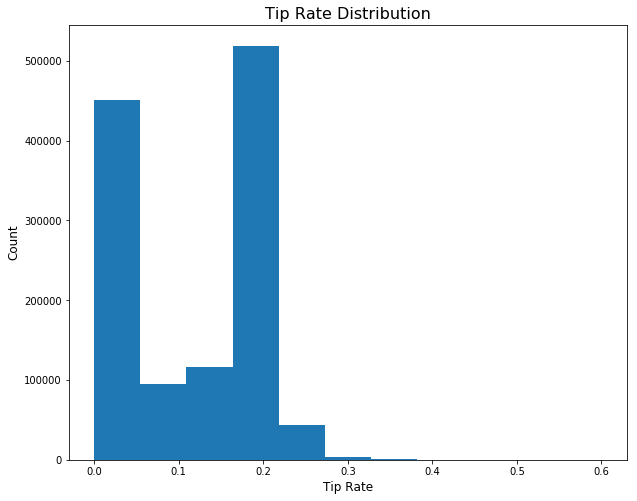

In [104]:
plt.subplots(figsize=(10,8))
plt.title('Tip Rate Distribution',fontsize=16)
plt.xlabel('Tip Rate', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.hist(final_df['tip_rate'], np.linspace(0,0.6,12))

Figure 1: Shown there a significant amount of people do not pay tax when taking yellow taxi

In [105]:
# It is really hard to predict wheather people pay tip or not
# Including tip rate at 0 significant decrease the performance of the model
# So I decided to drop the these rows

final_df = final_df.loc[final_df['tip_rate']!=0]

In [106]:
# save the prepared data
final_df.to_csv('final_Data.csv')

## Visualization ##

(array([  9133.,  95596., 116371., 519213.,  43379.,   3303.,    632.,
             0.,      0.,      0.,      0.]),
 array([0.        , 0.05454545, 0.10909091, 0.16363636, 0.21818182,
        0.27272727, 0.32727273, 0.38181818, 0.43636364, 0.49090909,
        0.54545455, 0.6       ]),
 <a list of 11 Patch objects>)

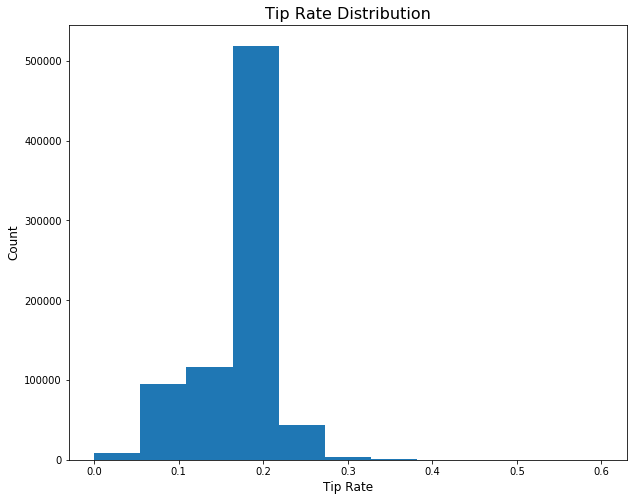

In [107]:
plt.subplots(figsize=(10,8))
plt.title('Tip Rate Distribution',fontsize=16)
plt.xlabel('Tip Rate', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.hist(final_df['tip_rate'], np.linspace(0,0.6,12))

Figure 1: The histogram shows normally people pay tips at a tip rate between 10% - 20%.

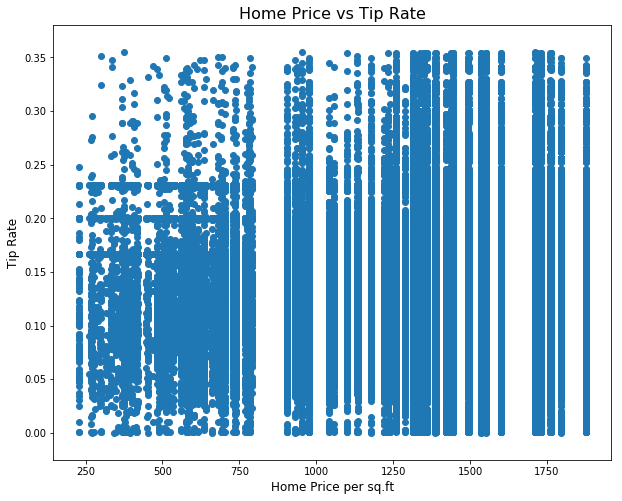

In [114]:
plt.subplots(figsize=(10,8))
plt.title('Home Price vs Tip Rate',fontsize=16)
plt.xlabel('Home Price per sq.ft', fontsize=12)
plt.ylabel('Tip Rate', fontsize=12)
plt.scatter(final_df['dropoff_homeprice'], final_df['tip_rate'])

Figure 2: The scatter plot shows that there are more people, who's drop off location has higer home price, pay high tip rate.

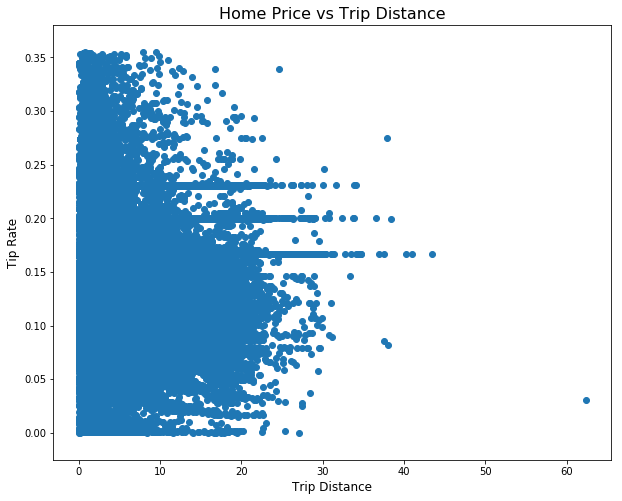

In [115]:
plt.subplots(figsize=(10,8))
plt.title('Home Price vs Trip Distance',fontsize=16)
plt.xlabel('Trip Distance', fontsize=12)
plt.ylabel('Tip Rate', fontsize=12)
plt.scatter(final_df['trip_distance'], final_df['tip_rate'])

Figure 3: The scatter plot shows that there's not a clear correlation between trip distance and tip rate.

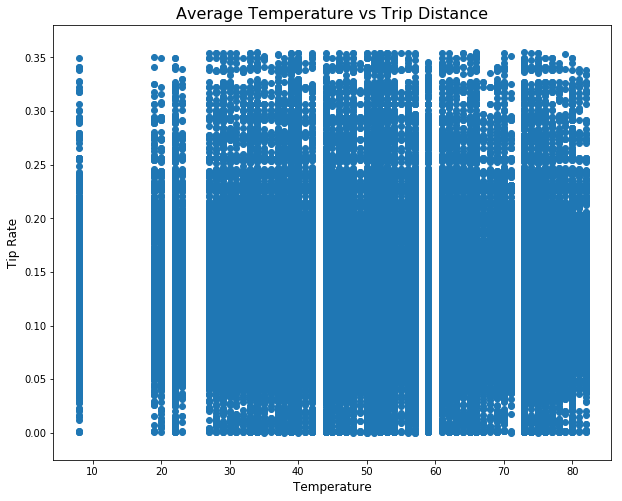

In [116]:
plt.subplots(figsize=(10,8))
plt.title('Average Temperature vs Trip Distance',fontsize=16)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Tip Rate', fontsize=12)
plt.scatter(final_df['pickup_tavg'], final_df['tip_rate'])

Figure 3: The scatter plot shows that there's not a clear correlation between tip rate and the average temperature at the day of trip.

## Modeling ##

In [117]:
# split train and test data (70% : 30%)
Train, Test = np.split(final_df.sample(frac=1, random_state=1), [int(.7*len(final_df))])

### Linear Regression with all variables ### 

In [118]:
RegressionModFull = smf.ols(formula='tip_rate ~ passenger_count + fare_amount + C(dropoff_county) + \
              C(pickup_time) + pickup_awnd + pickup_prcp + pickup_snow + pickup_snwd + pickup_tavg + \
                        dropoff_homeprice + trip_distance', 
                    data = Train).fit()

In [119]:
RegressionModFull.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tip_rate   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     401.7
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        18:38:19   Log-Likelihood:             1.0008e+06
No. Observations:              551338   AIC:                        -2.002e+06
Df Residuals:                  551321   BIC:                        -2.001e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1654      0.001    137.470      0.000       0.163       0.168
C(dropoff_county)[T.Kings]        0.0058      0.001      4.917      0.000       0.003       0.008
C(dropoff_county)[T.New York]    -0.0022      0.001     -1.910      0.056      -0.005    5.94e-05
C(dropoff_county)[T.Queens]       0.0056      0.001      4.746      0.000       0.003       0.008
C(dropoff_county)[T.Richmond]     0.0233      0.003      6.807      0.000       0.017       0.030
C(pickup_time)[T.Evening]        -0.0026      0.000    -19.054      0.000      -0.003      -0.002
C(pickup_time)[T.Midnight]       -0.0041      0.000    -20.957      0.000      -0.004      -0.004
C(pickup_time)[T.Morning]        -0.0015      0.000    -10.352      0.000      -0.002      -0.001
passenger_count                   0.0004   4.07e-05      8.758      0.000       0.000       0.000
fare_amount                      -0.0009   1.79e-05    -50.446      0.000      -0.001      -0.001
pickup_awnd                    4.947e-05    1.4e-05      3.534      0.000     2.2e-05    7.69e-05
pickup_prcp                      -0.0002      0.000     -0.856      0.392      -0.001       0.000
pickup_snow                       0.0002   6.32e-05      3.871      0.000       0.000       0.000
pickup_snwd                    8.263e-06    2.4e-05      0.344      0.731   -3.89e-05    5.54e-05
pickup_tavg                   -1.142e-05   3.82e-06     -2.992      0.003   -1.89e-05   -3.94e-06
dropoff_homeprice              2.521e-06   2.58e-07      9.772      0.000    2.02e-06    3.03e-06
trip_distance                     0.0014   5.19e-05     27.460      0.000       0.001       0.002
==============================================================================
Omnibus:                    35955.942   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74184.571
Skew:                          -0.450   Prob(JB):                         0.00
Kurtosis:                       4.555   Cond. No.                     9.86e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [120]:
PredDF = pd.DataFrame()
RegPred = RegressionModFull.predict(Test)
PredDF['FullModel'] = RegPred
mae1 = mean_absolute_error(Test['tip_rate'], PredDF['FullModel'])
print(mae1)

0.02743404647563379


### Linear Regression with significant variables ###

In [121]:
RegressionModRedu = smf.ols(formula='tip_rate ~ passenger_count + fare_amount + C(dropoff_county) + \
              C(pickup_time) + pickup_awnd + pickup_snow + pickup_tavg + dropoff_homeprice', 
                    data = Train).fit()

In [122]:
RegressionModRedu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tip_rate   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     435.8
Date:                Thu, 13 Dec 2018   Prob (F-statistic):               0.00
Time:                        18:38:23   Log-Likelihood:             1.0005e+06
No. Observations:              551338   AIC:                        -2.001e+06
Df Residuals:                  551324   BIC:                        -2.001e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1660      0.001    138.214      0.000       0.164       0.168
C(dropoff_county)[T.Kings]        0.0041      0.001      3.512      0.000       0.002       0.006
C(dropoff_county)[T.New York]    -0.0040      0.001     -3.378      0.001      -0.006      -0.002
C(dropoff_county)[T.Queens]       0.0040      0.001      3.409      0.001       0.002       0.006
C(dropoff_county)[T.Richmond]     0.0245      0.003      7.155      0.000       0.018       0.031
C(pickup_time)[T.Evening]        -0.0021      0.000    -15.901      0.000      -0.002      -0.002
C(pickup_time)[T.Midnight]       -0.0033      0.000    -17.052      0.000      -0.004      -0.003
C(pickup_time)[T.Morning]        -0.0014      0.000     -9.309      0.000      -0.002      -0.001
passenger_count                   0.0004   4.07e-05      8.921      0.000       0.000       0.000
fare_amount                      -0.0004   6.38e-06    -69.510      0.000      -0.000      -0.000
pickup_awnd                     4.94e-05   1.36e-05      3.627      0.000    2.27e-05    7.61e-05
pickup_snow                       0.0002   5.98e-05      3.722      0.000       0.000       0.000
pickup_tavg                   -1.622e-05   3.72e-06     -4.359      0.000   -2.35e-05   -8.92e-06
dropoff_homeprice              2.038e-06   2.58e-07      7.912      0.000    1.53e-06    2.54e-06
==============================================================================
Omnibus:                    36480.839   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74593.661
Skew:                          -0.458   Prob(JB):                         0.00
Kurtosis:                       4.551   Cond. No.                     9.86e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
RegPred = RegressionModRedu.predict(Test)
PredDF['ReducedModel'] = RegPred
mae2 = mean_absolute_error(Test['tip_rate'], PredDF['ReducedModel'])

### Deep Learning ###

In [124]:
DeepLearn_df = final_df.drop(columns=['pickup_prcp','pickup_snwd','trip_distance'])
DeepLearn_df = DeepLearn_df.join(pd.get_dummies(DeepLearn_df['dropoff_county']))
DeepLearn_df = DeepLearn_df.join(pd.get_dummies(DeepLearn_df['pickup_time']))

In [125]:
DeepLearn_df = DeepLearn_df.drop(columns=['dropoff_county','pickup_time'])
DLTrain, DLTest = np.split(DeepLearn_df.sample(frac=1, random_state=1), [int(.7*len(DeepLearn_df))])

In [126]:
DLTrainX = DLTrain.drop(columns=['tip_rate'])
DLTrainY = DLTrain[['tip_rate']]

DLTestX = DLTest.drop(columns=['tip_rate'])
DLTestY = DLTest[['tip_rate']]

In [127]:
dim = DLTrainX.shape[1]

In [128]:
np.random.seed(111)

DLModel = Sequential()
DLModel.add(Dense(units=32, activation='relu', input_dim=dim))
DLModel.add(Dense(units=64, activation='relu', input_dim=dim))
DLModel.add(Dense(units=64, activation='relu', input_dim=dim))
DLModel.add(Dense(units=32, activation='relu', input_dim=dim)
DLModel.add(Dense(units=1))

# Compile, fit, and generate scores and predicted probabilities.
DLModel.compile(loss='mae', optimizer='adam', metrics=['mae'])

#model.fit(data, labels, epochs=20, batch_size=100)
DLModel.fit(DLTrainX, DLTrainY, epochs=20, batch_size=200, verbose=2)

Epoch 1/20
 - 8s - loss: 0.8133 - mean_absolute_error: 0.8133
Epoch 2/20
 - 7s - loss: 0.1182 - mean_absolute_error: 0.1182
Epoch 3/20
 - 7s - loss: 0.0467 - mean_absolute_error: 0.0467
Epoch 4/20
 - 7s - loss: 0.0309 - mean_absolute_error: 0.0309
Epoch 5/20
 - 7s - loss: 0.0254 - mean_absolute_error: 0.0254
Epoch 6/20
 - 7s - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 7/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 8/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 9/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 10/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 11/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 12/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 13/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 14/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 15/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 16/20
 - 7s - loss: 0.0245 - mean_absolute_error: 0.0245
E

In [130]:
DLPred = DLModel.predict(DLTestX)
PredDF['DeepLearning'] = DLPred
mae3 = mean_absolute_error(DLTestY['tip_rate'], PredDF['DeepLearning'])
print(mae3)

0.024557946791895262


In [137]:
print('The Mean Absolute Error of Linear Regression Model with all Variables is ' + str(mae1)[0:6])
print('The Mean Absolute Error of Linear Regression Model with only significant Variables is ' + str(mae2)[0:6])
print('The Deep Learning Model with Only Significant Variables from Regression Model is ' + str(mae3)[0:6])

The Mean Absolute Error of Linear Regression Model with all Variables is 0.0274
The Mean Absolute Error of Linear Regression Model with only significant Variables is 0.0274
The Deep Learning Model with Only Significant Variables from Regression Model is 0.0245
